In [1]:
import os, scanpy, scprep
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import sys
sys.path.append('..')
from utils import *

In [2]:
backwards_path1 = "results/islet_run_endocrine_run1_growth/"
backwards_path2 = "results/islet_run_endocrine_run2_growth/"

In [5]:
adata = scanpy.read_h5ad('data/all_endocrine_processed.h5ad')
adata_wt = adata[adata.obs.samples == 'WT']
adata_obob = adata[adata.obs.samples == 'OB/OB']

In [6]:
gene ='Cck'
threshold = 0.0 # consider increasing to get only Cck-hi instead of Cck+

mask = adata_obob[:, (adata_obob.var['names'].isin(['Cck']))].to_df().values.flatten() > threshold
b_mask = mask & (adata_obob.obs['cell_types'] == 'Beta')
p_mask = mask & (adata_obob.obs['cell_types'] == 'Polyhormonal')

In [3]:
path1 = os.path.join(backwards_path1, 'backward_trajectories.npy')
path2 = os.path.join(backwards_path2, 'backward_trajectories.npy')

In [7]:
trajectories = np.load(path1)
trajectories = trajectories[:, mask, :]

<Axes: >

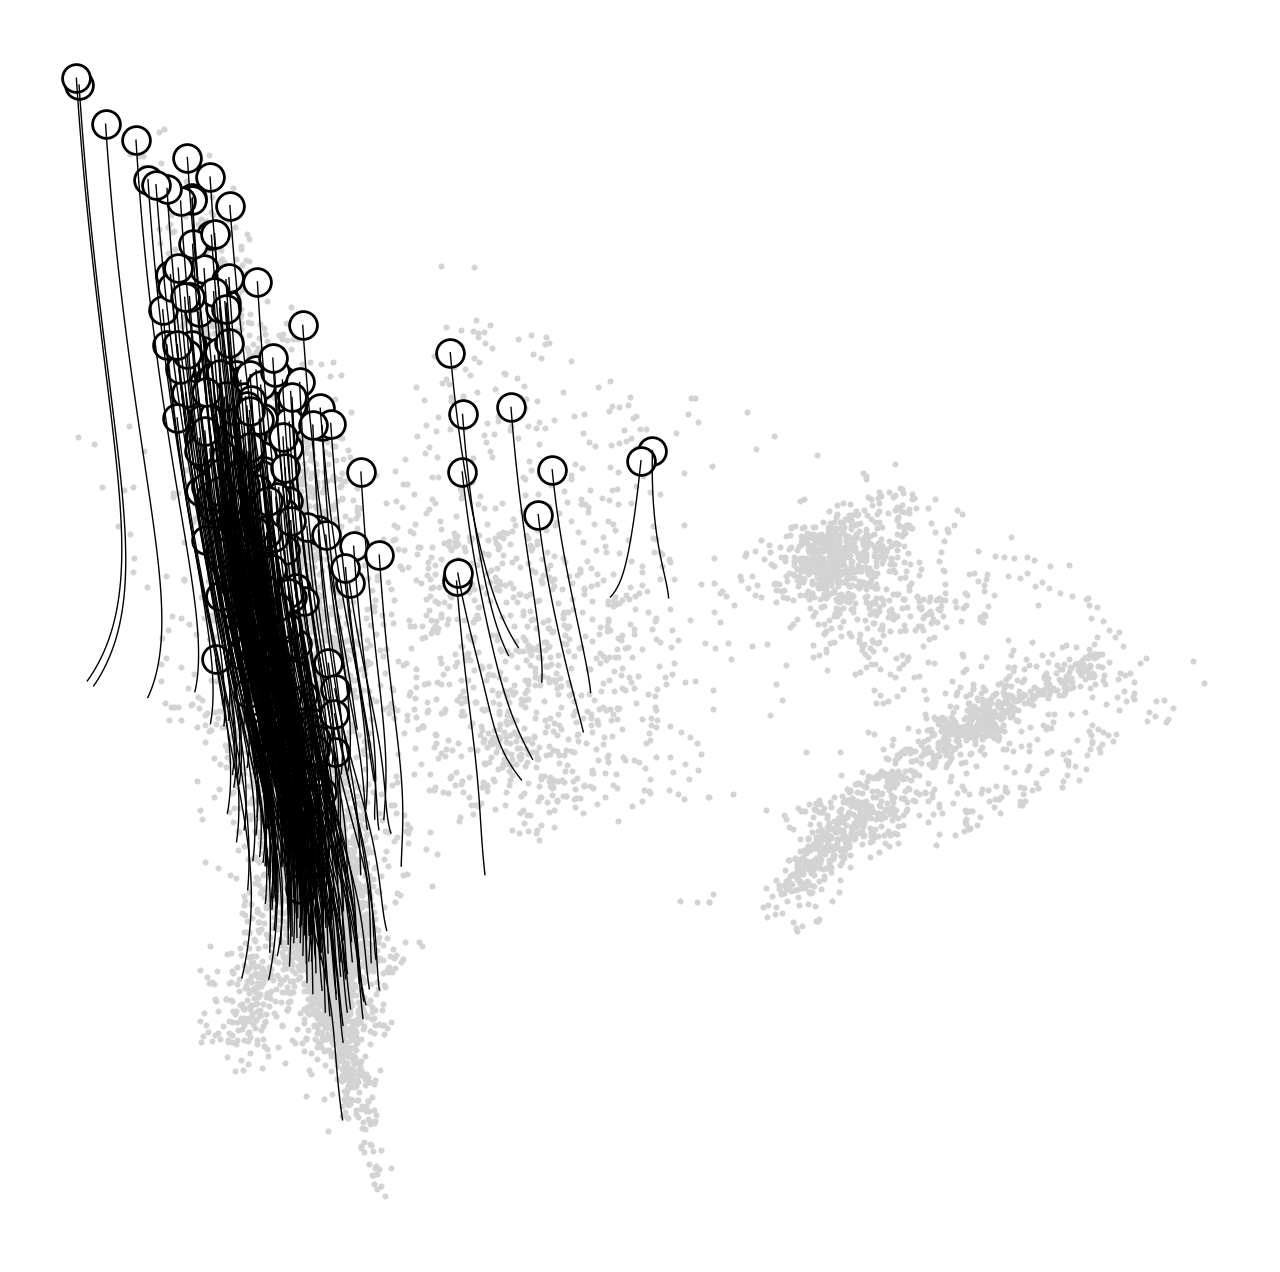

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=200)
ax.axis('off')
numlines = 300 # subset so lines are visible
for i in range(numlines):
    ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], linewidth=0.5, c="k")
    
scprep.plot.scatter2d(adata.obsm['data_magic_pc_norm'], c='lightgray', ticks=[], ax=ax)
scprep.plot.scatter2d(
    trajectories[0, :numlines, :],
    c="white",
    edgecolor='black',
    s=100,
    ax=ax,
    filename=f'figures/endocrine_{gene}_trajectories_run_1.png'
)

## Beta

In [42]:
expected = adata_wt.obs['cell_types'].value_counts() / adata_wt.n_obs # expected proportion of cell types

In [43]:
trajectories = np.array([np.load(path1),
                np.load(path2)])

In [46]:
pc_oe_ratios = []
for j in range(trajectories.shape[0]):
    # get cell-of-origin to Cck+ beta cells
    b_trajectories = trajectories[j][:, b_mask, :] 
    nearest_cells = get_cells_of_origin(b_trajectories, adata.obsm['data_magic_pc_norm'])

    # observed proportion of cell types in cell-of-origin to Cck+ beta cells
    # ratio of observed proportion to expected proportion
    ratio = (observed/expected).loc[adata.obs['cell_types'].cat.categories]
    pc_oe_ratios.append(ratio)
pc_oe_ratios = pd.concat(pc_oe_ratios)

cell_types
Beta            448
Polyhormonal      1
Alpha             0
Delta             0
PP                0
Name: count, dtype: int64
cell_types
Beta            448
Polyhormonal      1
Alpha             0
Delta             0
PP                0
Name: count, dtype: int64


/tmp/ipykernel_660200/964271108.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pc_oe_ratios.index,


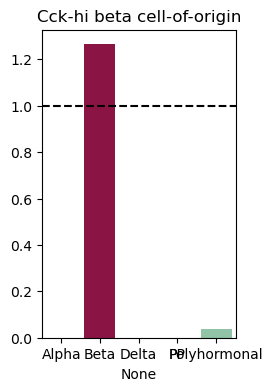

In [45]:
fig, ax = plt.subplots(figsize=(2.5,4))
sns.barplot(x=pc_oe_ratios.index,
            y=pc_oe_ratios.values,
            palette=['black', '#9e0142', 'black', 'black', '#88cca4'])

plt.axhline(1, c='black', linestyle='dashed')
plt.title(f'{gene}-hi beta cell-of-origin')
fig.savefig(f'figures/{gene}_trajectories_beta_coi_PCA.png', dpi=200)

## Poly

In [40]:
pc_oe_ratios = []
for j in range(trajectories.shape[0]):
    # get cell-of-origin to Cck+ beta cells
    p_trajectories = trajectories[j][:, p_mask, :] 
    nearest_cells = get_cells_of_origin(p_trajectories, adata.obsm['data_magic_pc_norm'])

    # observed proportion of cell types in cell-of-origin to Cck+ beta cells
    observed = adata.obs.iloc[nearest_cells]['cell_types'].value_counts() / adata[nearest_cells].n_obs
    
    # ratio of observed proportion to expected proportion
    ratio = (observed/expected).loc[adata.obs['cell_types'].cat.categories]
    pc_oe_ratios.append(ratio)
    print (observed)
pc_oe_ratios = pd.concat(pc_oe_ratios)

cell_types
Polyhormonal    1.0
Alpha           0.0
Beta            0.0
Delta           0.0
PP              0.0
Name: count, dtype: float64
cell_types
Polyhormonal    1.0
Alpha           0.0
Beta            0.0
Delta           0.0
PP              0.0
Name: count, dtype: float64


/tmp/ipykernel_660200/2668681167.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x.split(' cells')[0] for x in pc_oe_ratios.index],


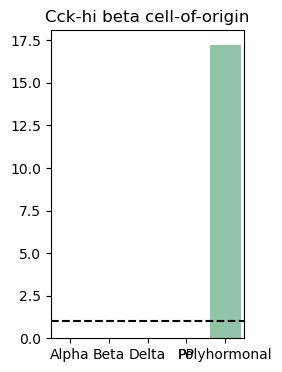

In [41]:
fig, ax = plt.subplots(figsize=(2.5,4))
sns.barplot(x=[x.split(' cells')[0] for x in pc_oe_ratios.index],
            y=pc_oe_ratios.values,
            palette=['black', '#9e0142', 'black', 'black', '#88cca4'])

plt.axhline(1, c='black', linestyle='dashed')
plt.title(f'{gene}-hi beta cell-of-origin')
fig.savefig(f'figures/{gene}_trajectories_poly_coi_PCA.png', dpi=200)